In [1]:
from volatility_surface_V2 import CubicSpline1D
import numpy as np
import pandas as pd
from newtonRaphson import newtonRaphson
from matplotlib import pyplot as plt
from tqdm import tqdm 
from scipy import special as sps

In [2]:
## CUBIC SPLINE SETUP  

# get bond price data
data = pd.read_csv("HW5Data.csv")
data = data.T
data.columns = data.iloc[0,:]
data.drop(["Maturity"], axis=0, inplace= True)

# uses cubic spline from Homework 4 to get interpolated bond prices and implied volatilities
x_knots = data.index.to_numpy(float)
CubicSpline = CubicSpline1D(x_knots)
prices_func = CubicSpline.gen_1d_spline_func(data.loc[:,"Price"].to_numpy(float))
imp_vol_func = CubicSpline.gen_1d_spline_func(data.loc[:,"Volatility"].to_numpy(float))

In [3]:
## SIMULATION INFORMATION
#------------------------------#
bond_maturity = 2
option_maturity = 1
dtime =  1/12
Par = 1
Strike = 0.9
L = 0.85
number_of_samples = 10000
#------------------------------#

### Question 1


In [4]:
## FUNCTION DECLARATIONS 
#-------------------------#
def payoff(S, K):
    """
    #### Call Payoff function 
    ##### INPUTS
    S:              vec         = vector or float of price \n
    K:              float       = stike price for the option \n
    ##### OUTPUTS
    payoff:         vec         = vector or float of the payof \n
    """
    return np.maximum(S - K, 0)

def btree_HoLee(dtime,time_steps:np.ndarray,bond_prices:np.ndarray,bond_imp_vol:np.ndarray,prec):
    """ 
    #### Creates a Ho-Lee Interest rate Binomail Tree
    ##### INPUTS
    dtime:          float       = time elapse between time steps \n
    time_steps:         np.ndarry   = vector of times up to the expiry of the underlying option, i.e. time_steps[-1] = bond_maturity \n
    bond_prices:    np.ndarry   = vector of market bond prices corrisponding to time at each time steps \n
    bond_imp_vol:   np.ndarry   = vector of market implied volatilites corrisponding to time at each time steps \n
    prec:           float       = precision for the newtwon raphson algorithm \n
    ##### OUTPUTS
    short_rate:     np.ndarry   = a 2d matrix for the trained interest rate model, each row denotes a possible outcome, collumns denote a specific time \n   
    """
    
    #declearing variabeles
    gamma = np.zeros(time_steps.shape)
    N_steps = len(time_steps)

    # finding gamma 0 and phi
    p0 = bond_prices[1]
    v0 = bond_imp_vol[2]
    gamma[0] = -(1/dtime)*np.log(p0)
    phi = -2*v0/np.sqrt(dtime)  
    
    # iteratively tunning gamma such that it matches market bond prices via newtow raphson
    for i in range(2,N_steps):       
        x0 = [gamma[i-2]]
        x,precMet,maxDev=newtonRaphson(
            userfunctions= lambda x: bondCalibrationErr(
                x ,
                iptr = i,
                dtime = dtime,
                bond_prices=bond_prices, 
                gamma= gamma,
                phi = phi),
            x = x0,
            prec = prec)
        gamma[i-1] = x[0]

    # creating short rate model under Ho-Lee 
    short_rate = np.zeros([N_steps,N_steps])                      
    for i in range(N_steps-2,-1,-1):            
        for j in range(i+1):
            short_rate[j,i] = gamma[i]+phi*j

    return short_rate

def bondCalibrationErr(x,iptr,dtime,phi,gamma,bond_prices):
    """
    #### Returs the Ho-Lee Model Calibration Error for Newton Raphson Algo
    ##### INPUTS
    x:              list    = the trial value for gamma[iptr] \n
    iptr:           int     = a integer "pointer" for current time (i*delta_t) \n
    phi:            float   = phi, a model parameter \n
    gamma:          vec     = a vector of known gamma values, gamma[i] for all 0 <= i < iptr \n
    bond_prices:    vec     = a vector market bond prices \n
    ##### OUPUTS
    g:              list    = the calibration error under the trial value \n
    """
    # intialise a bond price tree
    Bf= np.zeros([iptr+1,iptr+1])

    # set par value of bond at maturity
    Bf[:,-1] = 1

    # backwards iterating bond prices. Trial value of current gamma=x[0] and phi
    for i in range(iptr-1,-1,-1):
        if i == iptr-1:
            gamma_val = x[0]
        else:
            gamma_val = gamma[i]
        for j in range(0,i+1):
            Bf[j,i] = np.exp(-(gamma_val+phi*j)*dtime)*((1/2)*Bf[j,i+1]+(1/2)*Bf[j+1,i+1])

    # Bond price and volatility errors
    g=[bond_prices[iptr]-Bf[0,0]]

    return g

def gen_option_tree(short_rate,time_steps, dtime, par, option_maturity, strike, lowb):
    """
    #### Generate the option and bond prices trees
    ##### INPUTS
    short_rate:         np.ndarry   = a 2d matrix for the trained interest rate model, each row denotes a possible outcome, collumns denote a specific time \n 
    time_steps:         np.ndarry   = vector of times up to the expiry of the underlying option, i.e. time_steps[-1] = bond_maturity \n
    dtime:              float       = time elapse between time steps \n
    par:                float       = the par value of the underlying bond for the option \n
    option_maturity:    float       = the time at which the option expire \n
    strike:             float       = the call option strike price \n
    lowb:               float       = the knock out lower boundary bond price boundary \n
    ##### OUTPUTS
    option_tree:        np.ndarry   = a 2d matrix for the option price model, each row denotes a possible outcome, collumns denote a specific time \n
    bond_tree:          np.ndarry   = a 2d matrix for the bond price model, each row denotes a possible outcome, collumns denote a specific time \n
    """
    # intialising the bond tree from t = 0 to t = T*, set maturity payoff to par
    N_steps = len(time_steps)
    bond_tree = np.zeros([N_steps, N_steps])
    bond_tree[:,-1]=par

    # backward iterating bond price back from matuiry to current time under the interest rate model
    for i in range(N_steps-2,-1,-1):
        for j in range(i+1):
            bond_tree[j,i] = np.exp(-short_rate[j,i]*dtime) * ((1/2)*bond_tree[j+1,i+1] + (1/2)*bond_tree[j,i+1])

    # initalising option tree trom t = 0 to t = T
    at_option_maturity = int(option_maturity/dtime)
    option_tree = np.zeros([at_option_maturity+1,at_option_maturity+1])

    # set option maturity to the call payoff of the underly bond at t=T, as well as apply the knockout condition at the payoff 
    option_tree[:,at_option_maturity] = payoff(bond_tree[:at_option_maturity+1,at_option_maturity],strike)
    option_tree[:,at_option_maturity] = np.where(bond_tree[:at_option_maturity+1,at_option_maturity]<=lowb,0,option_tree[:,at_option_maturity])

    # backwards iterating the option price back to the current time, applying the knockout condition at each step
    for i in range(at_option_maturity-1,-1,-1):
        for j in range(i+1):
            option_tree[j,i] = np.exp(-short_rate[j,i]*dtime)*((1/2)*option_tree[j+1,i+1]+(1/2)*option_tree[j,i+1])
        
        option_tree[:,i] = np.where(bond_tree[:at_option_maturity+1,i]<=lowb,0,option_tree[:,i])

    return option_tree, bond_tree
#-------------------------#

In [5]:
# INITALISATION
# set up time structure and evaluate corrisponding bond data using cublic spline 
time_steps = np.arange(0,bond_maturity+round(dtime,3),dtime).round(4)
bond_prices = CubicSpline.eval_vec(prices_func,time_steps,True)
bond_imp_vols = CubicSpline.eval_vec(imp_vol_func,time_steps,True)

## EVALUATION 
# create interest rate tree, bond price tree and option price tree
short_rate = btree_HoLee(dtime,time_steps,bond_prices,bond_imp_vols,1e-14)
option_tree, bond_tree = gen_option_tree(short_rate,time_steps,dtime,1,1,Strike,L)

### Question 2


In [6]:
# set up time strucutre,  note a extra time step due to needing to evaluate Pn for dF/dt at bond maturity
time_steps = np.arange(0,bond_maturity+2*round(dtime,3),dtime).round(4) 
number_of_steps = int(bond_maturity/dtime)
point_at_option_maturity = int(option_maturity/dtime)

# Evaluating CubicSpine Bond Information B_0(t) & v_0(t) 
bond_prices = CubicSpline.eval_vec(prices_func,time_steps,True)
bond_imp_vol = CubicSpline.eval_vec(imp_vol_func,time_steps,True)

# initialising r0, sigma 
v0 = CubicSpline.eval_point(imp_vol_func,dtime)
P0 = CubicSpline.eval_point(prices_func,dtime)
sigma = (1/dtime)*v0
r0 = -(1/dtime)*np.log(P0)

# interest rate paths
r_path_np = np.zeros([number_of_steps+1,number_of_samples])

# bond price paths 
bond_path_np = np.zeros([number_of_steps+1,number_of_samples])
bond_path_np[number_of_steps,:] = Par

# option price paths 
option_path_np = np.zeros([point_at_option_maturity+1,number_of_samples])


In [7]:
## SAMPLING FOR INTEREST RATE PATHS
for i in tqdm(range(number_of_steps+1)):
    time = time_steps[i]

    # Finding the time differential of the foward short rate
    if i == 0:
        j = 1
    else:
        j = i
    
    Po = bond_prices[j-1]
    Pi = bond_prices[j]
    Pn = bond_prices[j+1]

    div_F0 = ((1/dtime)**2)*np.log((Pi**2)/(Po*Pn))

    # finding the mean and sampling 
    mean = (div_F0 + sigma**2*time)*dtime
    std = sigma*np.sqrt(dtime)
    dr = np.random.normal(mean,std,number_of_samples)
    
    # checking if the sample causes the interest rate to be negative, if so resample
    if i == 0:
        rc = pd.Series(r0,index=range(number_of_samples))
    else:
        rc = r_path_np[i-1,:]  
        rc = pd.Series(rc) 

    ri = rc + dr

    # resampling for negative interest rates, until there's no violation
    while ri[ri<0].shape[0] > 0:
        dr = np.random.normal(mean,std,ri[ri<0].shape[0])
        ri[ri<0] = rc[ri<0] + dr 

    # updating interest rate paths
    r_path_np[i,:] = ri.to_numpy()

100%|██████████| 25/25 [00:00<00:00, 374.14it/s]


In [8]:
## FINDING BOND PRICE PATHS GIVEN INTEREST RATE PATHS 

for i in tqdm(range(number_of_steps-1,-1,-1)):
    # discounting back by P_i-1 = e^(-ri*dtime)*Pi
    curr_bond_price = bond_path_np[i+1]
    curr_r = r_path_np[i+1]

    bond_path_np[i,:] = np.exp(-curr_r*dtime)*curr_bond_price

100%|██████████| 24/24 [00:00<00:00, 4010.65it/s]


In [9]:
## FINDING OPTION PRICE PATHS GIVEN INTEREST RATE & BOND PRICE PATHS

# Terminal payoff C_T = max{P_T-K,0}
option_path_np[point_at_option_maturity] = np.maximum(bond_path_np[point_at_option_maturity]-Strike,0)

# knockout condition C_T = 0 if P_T < L 
option_path_np[point_at_option_maturity] = np.where(bond_path_np[point_at_option_maturity]<=L,0,option_path_np[point_at_option_maturity])

for i in tqdm(range(point_at_option_maturity-1,-1,-1)):
    curr_option_price = option_path_np[i+1]
    curr_bond_price = bond_path_np[i+1]
    
    # knockout C_t = 0  if P_t < L
    curr_option_price = np.where(curr_bond_price<=L, 0, curr_option_price)

    # discount C_t-1 = e^(-r_t*dtime)*C_t
    curr_r = r_path_np[i+1]
    option_path_np[i,:] = np.exp(-curr_r*dtime)*curr_option_price

100%|██████████| 12/12 [00:00<00:00, 6011.90it/s]


### Comparison of results

In [10]:
print("Interest Rate Tree:  {}".format(round(option_tree[0,0],5)))
print("Monte Carlo:         {} +- {}".format(round(option_path_np[0].mean(),5),round(option_path_np[0].std()/np.sqrt(number_of_samples),5)))

Interest Rate Tree:  0.04753
Monte Carlo:         0.04794 +- 0.00011


C:\Users\ChunMing\AppData\Local\Temp\ipykernel_24236\3137050651.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  r_mean = pd.Series()
C:\Users\ChunMing\AppData\Local\Temp\ipykernel_24236\3137050651.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bond_mean = pd.Series()
C:\Users\ChunMing\AppData\Local\Temp\ipykernel_24236\3137050651.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  option_mean = pd.Series()


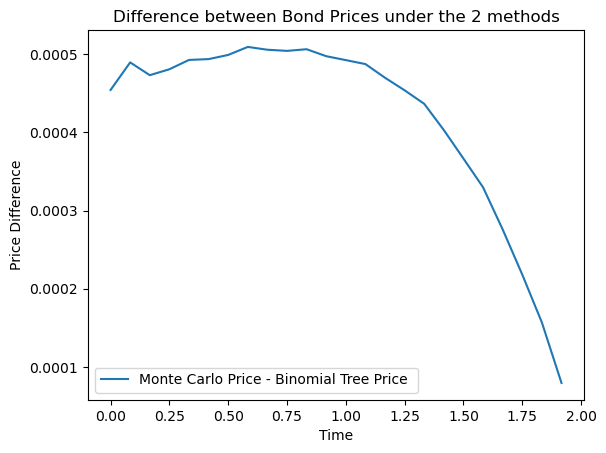

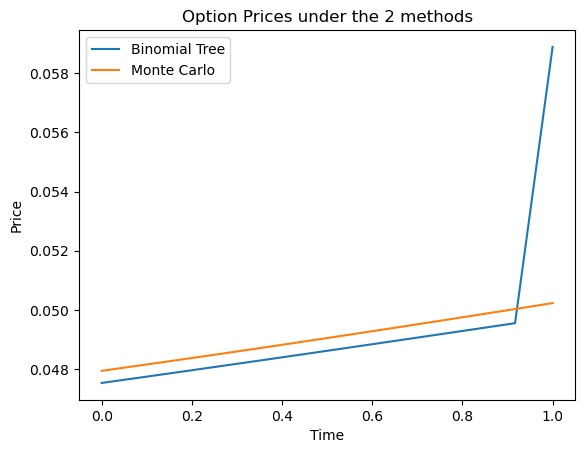

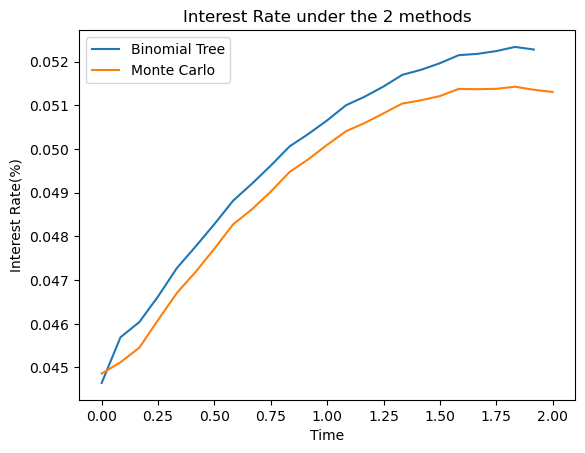

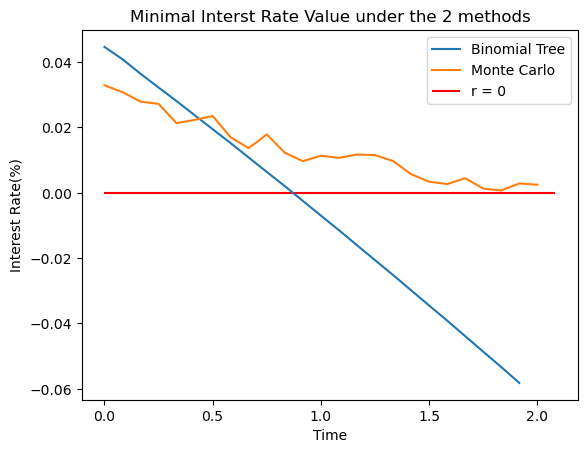

In [11]:
option_BT_df = pd.DataFrame(option_tree).T
option_BT_df[option_BT_df==0] = np.nan
option_MC_df = pd.DataFrame(option_path_np)

bond_BT_df = pd.DataFrame(bond_tree).T
bond_BT_df[bond_BT_df==0] = np.nan
bond_MC_df = pd.DataFrame(bond_path_np)

r_BT_df = pd.DataFrame(short_rate).T
r_BT_df[r_BT_df==0] = np.nan
r_MC_df = pd.DataFrame(r_path_np)

r_mean = pd.Series()
bond_mean = pd.Series()
option_mean = pd.Series()
for i in range(number_of_steps):
    tb = bond_BT_df.iloc[i,:].dropna()
    tr = r_BT_df.iloc[i,:].dropna()
    c = sps.comb(len(tb)*[i],np.arange(0,len(tr)))
    
    bond_mean.at[i] = (tb*c).sum()/c.sum()
    r_mean.at[i] = (tr*c).sum()/c.sum()

for i in range(point_at_option_maturity+1):
    tp = option_BT_df.iloc[i,:].dropna()
    c = sps.comb(len(tp)*[i],np.arange(0,len(tp)))
    
    option_mean.at[i] = (tp*c).sum()/c.sum()

    

plt.figure(1)
plt.plot(time_steps[:-1],-bond_mean+bond_MC_df.mean(1))
# plt.plot(time_steps[:-1],bond_MC_df.mean(1))
plt.title("Difference between Bond Prices under the 2 methods")
plt.xlabel("Time")
plt.ylabel("Price Difference")
plt.legend(["Monte Carlo Price - Binomial Tree Price "])

plt.figure(2)
plt.plot(time_steps[:point_at_option_maturity+1],option_mean)
plt.plot(time_steps[:point_at_option_maturity+1],option_MC_df.mean(1))
plt.title("Option Prices under the 2 methods")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["Binomial Tree", "Monte Carlo"])

plt.figure(3)
plt.plot(time_steps[:-2],r_mean)
plt.plot(time_steps[:-1],r_MC_df.mean(1))
plt.title("Interest Rate under the 2 methods")
plt.xlabel("Time")
plt.ylabel("Interest Rate(%)")
plt.legend(["Binomial Tree", "Monte Carlo"])

plt.figure(4)
plt.plot(time_steps[:-1],r_BT_df.min(1))
plt.plot(time_steps[:-1],r_MC_df.min(1))
plt.hlines(0,time_steps[0],time_steps[-1],'r')
plt.title("Minimal Interst Rate Value under the 2 methods")
plt.xlabel("Time")
plt.ylabel("Interest Rate(%)")
plt.legend(["Binomial Tree", "Monte Carlo", "r = 0"])
